In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
from scipy.io import loadmat
import os
for i in os.listdir():
    if 'mat' in i:
        print(i)

ex4data1.mat
ex4weights.mat


In [3]:
data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')

In [4]:
images = data['X']
label = data['y']

In [5]:
# label[label==10]=0

In [6]:
M,N = images.shape
L= 21  # no. of units in the hidden layer, inlcuding bias
k = len(np.unique(label))   # no. of distinct classes (10)

In [7]:
X = np.append(np.ones((M,1)), images, axis=1)

In [8]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

# one hot encoding to labels

In [9]:
Y = np.array(pd.get_dummies(label.flatten()), dtype=np.float64)

# Random Values of theta

In [10]:
theta1 = np.random.rand(L-1, N+1)
theta2 = np.random.rand(L-1,L)
theta3 = np.random.rand(k,L)

In [11]:
initial_nn_params = np.concatenate((theta1.flatten(), theta2.flatten(), theta3.flatten()))

# Cost Function and Gradient Descent Algorithm

In [12]:
def sigmoidGradient(z):
    x = sigmoid(z)
    return x * (1-x)

In [13]:
def nnCostFunction_grad(nn_params,X, y, lam_):

    theta_1 = nn_params[:np.product((L-1, N+1))].reshape(L-1,N+1) # for theta1
    theta_2 = nn_params[np.product((L-1, N+1)): -np.product((L, k))].reshape(L-1,L)
    theta_3 = nn_params[-np.product((L, k)):].reshape(k,L)
    
    a1 = X
    z2 = np.dot(a1, theta_1.T)
    a2 = sigmoid(z2)
    a2 = np.append(np.ones((M,1)), a2,axis=1)
    z3 = np.dot(a2,theta_2.T)
    a3 = sigmoid(z3)
    a3 = np.append(np.ones((M,1)), a3,axis=1)
    z4 = np.dot(a3,theta_3.T)
    a4 = sigmoid(z4)

    ########### cost ####################
    J=0
    for i in range(k):
        J = J + sum(-y[:,i] * np.log(a4[:,i]) - (1-y[:,i])*np.log(1-a4[:,i]))
    cost = J/M
    
    reg_ = 0
    # no. of layers are 4 hence 3 theta matrices
    for i in [theta_1,theta_2,theta_3]:
        reg_ = reg_ + np.sum(np.square(i[:,1:]))
        # taking square of theta from 0th term won't make any difference, it is just better to not include the bias term.
    reg_J = cost + lam_/(2*M) * reg_
    
    ######## Gradients ##############
    
                                                            
    d4 = a4-y                                               # dL = h(x) - y
    d3 = (np.dot(d4,theta_3[:,1:]) * sigmoidGradient(z3))   # dL-1  = np.dot(dL, theta(i)[:,1:]) * sigmoid(z(i))
    d2 = (np.dot(d3,theta_2[:,1:]) * sigmoidGradient(z2))   # dL-2  = np.dot(dL-1, theta(i)[:,1:]) * sigmoid(z(i))
                                                            # we will not calculate d1, 
                                                            # since error for the first layer doesnot exist as it contains the input values
    delta1 = np.dot(d2.T,a1)           # deltai = np.dot(di+1.T, ai)  a1=X  
    delta2 = np.dot(d3.T,a2)
    delta3 = np.dot(d4.T,a3)                          
    
    theta1_ = np.append(np.ones((len(theta_1), 1)), theta_1[:,1:],axis=1)
    theta2_ = np.append(np.ones((len(theta_2), 1)), theta_2[:,1:],axis=1)
    theta3_ = np.append(np.ones((len(theta_3), 1)), theta_3[:,1:],axis=1)

    theta1_grad = (delta1/M) + ((lam_/M) * theta1_)
    theta2_grad = (delta2/M) + ((lam_/M) * theta2_)
    theta3_grad = (delta3/M) + ((lam_/M) * theta3_)

    # theta1_grad and theta1 will be of the same dimensions, so will theta2_grad and theta2
    
    grad = np.concatenate((theta1_grad.flatten(),theta2_grad.flatten(), theta3_grad.flatten()))
    return(reg_J, grad)

In [14]:
print('Non-regularized Cost Value: {}'.format(nnCostFunction_grad(initial_nn_params,X,Y,0)[0]))
print('Regularized Cost Value:\t {}'.format(nnCostFunction_grad(initial_nn_params,X,Y,1)[0]))

Non-regularized Cost Value: 99.83310461312281
Regularized Cost Value:	 100.11862224992568


In [15]:
from scipy.optimize import minimize
res = minimize(nnCostFunction_grad,initial_nn_params, 
               method='L-BFGS-B', args=(X,Y,1), jac=True, options={'maxiter': 200})

# Evaluating

In [16]:
all_theta = res['x']

In [17]:
def pred(nn_params,X,y):
        
    theta_1 = nn_params[:np.product((L-1, N+1))].reshape(L-1,N+1) # for theta1
    theta_2 = nn_params[np.product((L-1, N+1)): -np.product((L, k))].reshape(L-1,L)
    theta_3 = nn_params[-np.product((L, k)):].reshape(k,L)
    
    a1 = X
    z2 = np.dot(a1, theta_1.T)
    a2 = sigmoid(z2)
    a2 = np.append(np.ones((M,1)), a2,axis=1)
    z3 = np.dot(a2,theta_2.T)
    a3 = sigmoid(z3)
    a3 = np.append(np.ones((M,1)), a3,axis=1)
    z4 = np.dot(a3,theta_3.T)
    a4 = sigmoid(z4)

    
    return a4.argmax(axis=1).reshape(-1,1) + 1

In [18]:
def accuracy(nn_params,X,y):
    
    a4 = pred(nn_params,X,y)
    return np.mean(a4== label)

In [19]:
predicted = pred(all_theta,X,Y)

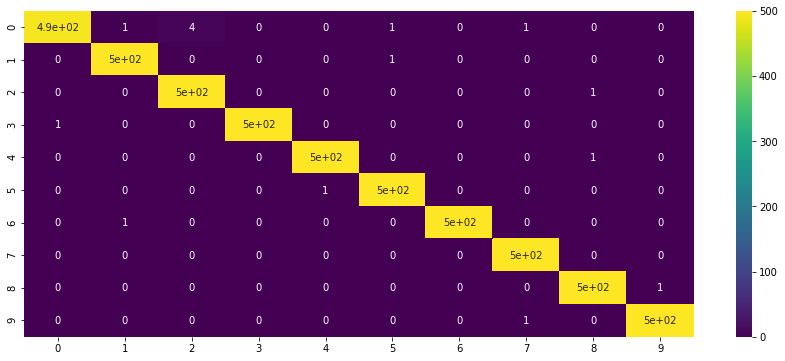

In [20]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15,6))
sns.heatmap(confusion_matrix(label,predicted), cmap='viridis',annot=True)

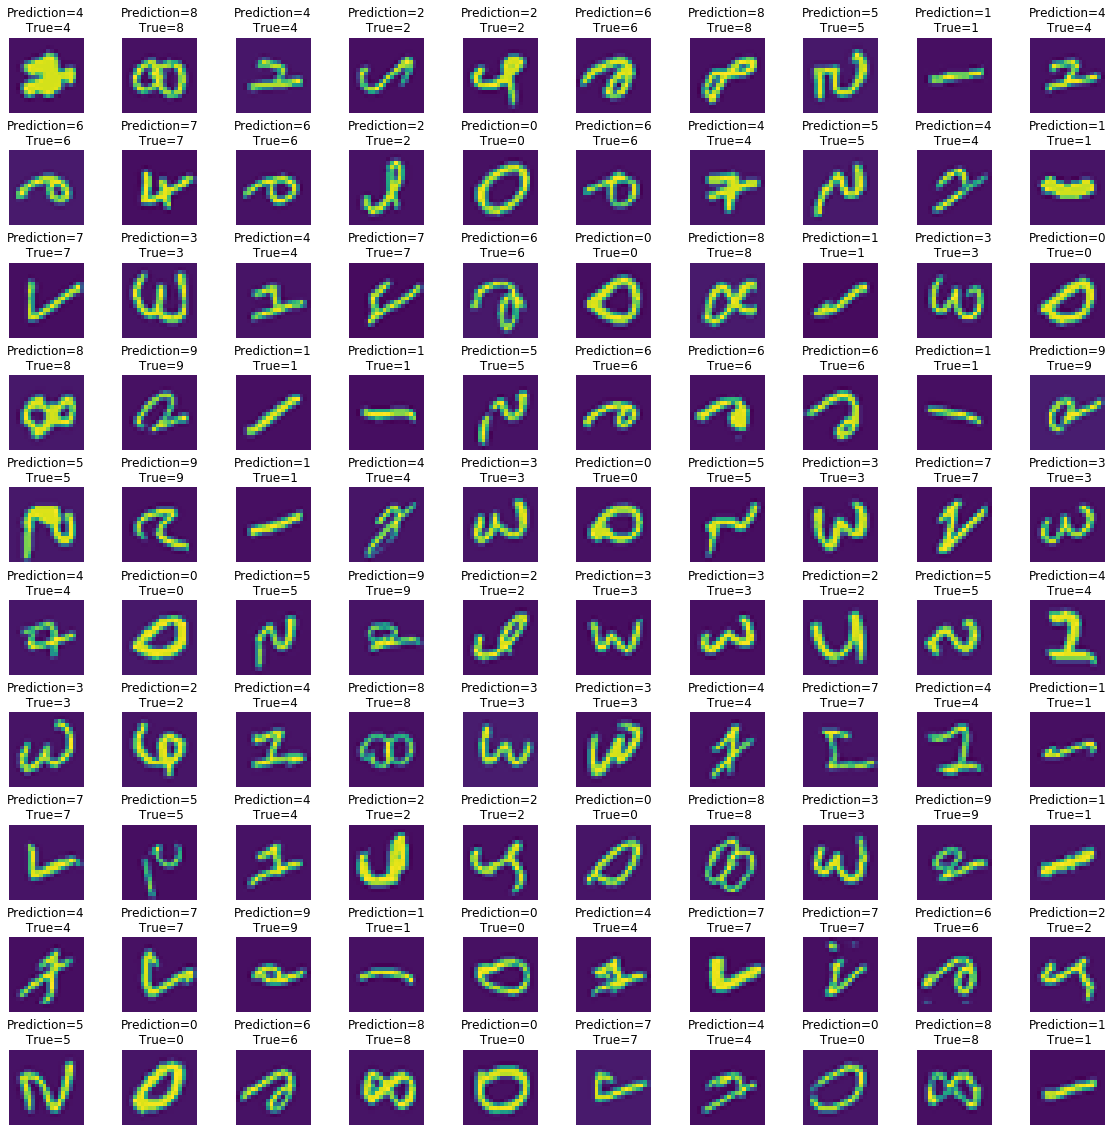

In [21]:
label[label==10] = 0
predicted[predicted==10]=0
rows = 10
cols=10
fig, axes = plt.subplots(rows,cols, figsize=(20,20))
axes = axes.flatten()
training_data = len(images)
for i in np.arange(0,rows*cols):
    index = np.random.randint(0, training_data)
    axes[i].imshow(images[index].reshape(20,20))
    axes[i].axis('off')
    axes[i].set_title("Prediction={}\n True={}".format(predicted[index][0], label[index][0]))
plt.subplots_adjust(hspace=0.5)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(label,predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      0.99      0.99       500
           2       1.00      1.00      1.00       500
           3       0.99      1.00      1.00       500
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       1.00      1.00      1.00       500
           8       1.00      1.00      1.00       500
           9       1.00      1.00      1.00       500

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

